<a href="https://colab.research.google.com/github/PsorTheDoctor/Sekcja-SI/blob/master/neural_networks/GAN/StarGAN/stargan_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# StarGAN: Transfer Learning

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch

In [0]:
channels = 3
img_width = 128
img_height = 128
img_shape = (channels, img_width, img_height)
residual_blocks = 6

# wybrane atrybuty do zbioru danych CelebA
selected_attrs = ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']
c_dim = len(selected_attrs)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
class ResidualBlock(nn.Module):
  def __init__(self, in_features):
    super(ResidualBlock, self).__init__()

    conv_block = [
      nn.Conv2d(in_features, in_features, 3, stride=1, padding=1, bias=False),
      nn.InstanceNorm2d(in_features, affine=True, track_running_stats=True),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_features, in_features, 3, stride=1, padding=1, bias=False),
      nn.InstanceNorm2d(in_features, affine=True, track_running_stats=True),
    ]

    self.conv_block = nn.Sequential(*conv_block)

  def forward(self, x):
    return x + self.conv_block(x)

In [0]:
class GeneratorResNet(nn.Module):
  def __init__(self, img_shape=(3, 128, 128), res_blocks=9, c_dim=5):
    super(GeneratorResNet, self).__init__()
    channels, img_size, _ = img_shape

    # Wstępny blok konwolucyjny
    model = [
      nn.Conv2d(channels + c_dim, 64, 7, stride=1, padding=3, bias=False),
      nn.InstanceNorm2d(64, affine=True, track_running_stats=True),
      nn.ReLU(inplace=True)
    ]

    # Próbkowanie w dół
    curr_dim = 64
    for _ in range(2):
      model += [
        nn.Conv2d(curr_dim, curr_dim * 2, 4, stride=2, padding=1, bias=False),
        nn.InstanceNorm2d(curr_dim* 2, affine=True, track_running_stats=True),
        nn.ReLU(inplace=True),
      ]
      curr_dim *= 2

    # Pozostałe bloki
    for _ in range(res_blocks):
      model += [ResidualBlock(curr_dim)]

    # Próbkowanie w górę
    for _ in range(2):
      model += [
        nn.ConvTranspose2d(curr_dim, curr_dim // 2, 4, stride=2, padding=1, bias=False),
        nn.InstanceNorm2d(curr_dim // 2, affine=True, track_running_stats=True),
        nn.ReLU(inplace=True),
      ]
      curr_dim = curr_dim // 2
    
    # Warstwa wyjściowa
    model += [nn.Conv2d(curr_dim, channels, 7, stride=1, padding=3), nn.Tanh()]

    self.model = nn.Sequential(*model)

  def forward(self, x, c):
    c = c.view(c.size(0), c.size(1), 1, 1)
    c = c.repeat(1, 1, x.size(2), x.size(3))
    x = torch.cat((x, c), 1)
    return self.model(x)

In [0]:
class Discriminator(nn.Module):
  def __init__(self, img_shape=(3, 128, 128), c_dim=5, n_strided=6):
    super(Discriminator, self).__init__()
    channels, img_size, _ = img_shape

    def discriminator_block(in_filters, out_filters):
      """Zwraca próbkowane w dół warstwy każdego bloku dyskryminatora"""
      layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1), nn.LeakyReLU(0.01)]
      return layers

    layers = discriminator_block(channels, 64)
    curr_dim = 64
    for _ in range(n_strided - 1):
      layers.extend(discriminator_block(curr_dim, curr_dim * 2))
      curr_dim *= 2

    self.model = nn.Sequential(*layers)

    # Wyjście 1: PatchGAN
    self.out1 = nn.Conv2d(curr_dim, 1, 3, padding=1, bias=False)
    # Wyjście 2: Predykcja klasy
    kernel_size = img_size // 2 ** n_strided
    self.out2 = nn.Conv2d(curr_dim, c_dim, kernel_size, bias=False)

  def forward(self, img):
    feature_repr = self.model(img)
    out_adv = self.out1(feature_repr)
    out_cls = self.out2(feature_repr)
    return out_adv, out_cls.view(out_cls.size(0), -1)

In [0]:
PATH_G = '/content/drive/My Drive/saved_models/generator_199.pth'
PATH_D = '/content/drive/My Drive/saved_models/discriminator_199.pth'

In [13]:
model_G = GeneratorResNet(img_shape=img_shape, res_blocks=residual_blocks, c_dim=c_dim)
model_D = Discriminator(img_shape=img_shape, c_dim=c_dim)

# Jeśli jesteśmy na GPU:
# model_G.load_state_dict(torch.load(PATH_G))

# Jeśli jesteśmy na CPU:
model_G.load_state_dict(torch.load(PATH_G, map_location=torch.device('cpu')))
model_D.load_state_dict(torch.load(PATH_D, map_location=torch.device('cpu')))

# model_G.eval()

<All keys matched successfully>

In [0]:
import glob
import random
import os
import numpy as np
import torch

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

In [0]:
class CelebADataset(Dataset):
  def __init__(self, root, transforms_=None, mode='train', attributes=None):
    self.transform = transforms.Compose(transforms_)

    self.selected_attrs = attributes 
    self.files = sorted(glob.glob('%s/*.jpg' % root))
    self.mode = mode

    if self.mode == 'train':
      self.files = self.files[:-2000] 
    elif self.mode == 'val':
      self.files = self.files[-2000:]
    else:
      self.files = self.files[0]

    self.label_path = glob.glob('%s/*.txt' % root)[0]
    self.annotations = self.get_annotations()

  def get_annotations(self):
    """Wyodrębnia adnotacje dla CelebA"""
    annotations = {}
    lines = [line.rstrip() for line in open(self.label_path, 'r')]
    self.label_names = lines[1].split()
    for _, line in enumerate(lines[2:]):
      filename, *values = line.split()
      labels = []
      for attr in self.selected_attrs:
        idx = self.label_names.index(attr)
        labels.append(1 * (values[idx] == '1'))
      annotations[filename] = labels
    return annotations

  def __getitem__(self, index):
    if self.mode != 'prod':
      filepath = self.files[index % len(self.files)]
      filename = filepath.split('/')[-1]
      label = self.annotations[filename]
    else:
      # TODO!
      filepath = '/content/drive/My Drive/uploaded_images/adam.jpg'
      filename = 'adam.jpg'
      label = self.annotations['000001.jpg']

    img = self.transform(Image.open(filepath))
    label = torch.FloatTensor(np.array(label))

    return img, label

  def __len__(self):
    return len(self.files)

In [0]:
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [0]:
prod_transforms = [
  transforms.Resize((img_height, img_width), Image.BICUBIC),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

In [0]:
prod_dataloader = DataLoader(
    CelebADataset(
        '/content/drive/My Drive/uploaded_images', 
        transforms_=prod_transforms, 
        mode='prod', 
        attributes=selected_attrs
    ),
    batch_size=1,
    shuffle=False,
    num_workers=1,
)

In [0]:
# Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
Tensor = torch.FloatTensor

In [0]:
# Działa tylko dla selected_attrs = ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']!

# (a, b)
# a      - indeks cechy w selected_attrs, do której się odwołujemy
# b = -1 - negacja 
# b = 0  - obojętność
# b = 1  - wystąpienie

label_changes = [
  ((0, 1), (1, 0), (2, 0)),  # Ustawienie czarnych włosów
  ((0, 0), (1, 1), (2, 0)),  # Ustawienie blond włosów
  ((0, 0), (1, 0), (2, 1)),  # Ustawienie brązowych włosów
  ((3, -1),),  # Zmiana płci
  ((4, -1),),  # Zmiana wieku
]

In [0]:
def produce_image():
  """Zapis wygenerowanej próbki"""
  prod_imgs, prod_labels = next(iter(prod_dataloader))
  prod_imgs = Variable(prod_imgs.type(Tensor))
  prod_labels = Variable(prod_labels.type(Tensor))
  img_samples = None

  img, label = prod_imgs[0], prod_labels[0]
    
  imgs = img.repeat(c_dim, 1, 1, 1)
  labels = label.repeat(c_dim, 1)

  gen_imgs = model_G(imgs, labels)
  gen_imgs = torch.cat([x for x in gen_imgs.data], -1)
  img_sample = torch.cat((img.data, gen_imgs), -1)

  img_samples = img_sample if img_samples is None else torch.cat((img_samples, img_sample), -2)

  save_image(img_samples.view(1, *img_samples.shape), 'produced_images/prod1.png', normalize=True)

In [0]:
produce_image()

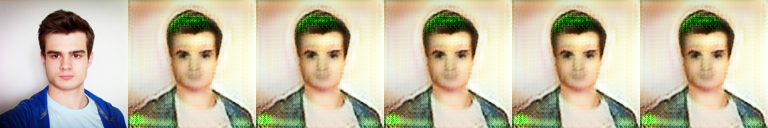

In [34]:
prod_img = Image.open('produced_images/prod1.png')
prod_img